In [4]:
import os
# import pandas as pd 
import polars as pl
# import scanpy as sc
import numpy as np
import typing as tp
import re
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import umap as umap
import hdbscan as hdb

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

2024-05-03 14:29:34.063571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/scratch2-shared/david/sartoriusNB'

In [5]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./output/bfmoalive_pilot/2_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/bfmoalive_pilot/1_FeaturesImages'


In [6]:
filenames = ['bfmoalive_A549_PE_48h_240312_L1_CP']
statmets = ['SingleCell', 'MedianCell', 'MeanCell']

dropcols = ['Nuclei_Location_Center_X',
            'Nuclei_Location_Center_Y',
            'Location',
            'ImageNumber_',
            'Parent',
            'Children',
            '_ObjectNumber',
            '_Object_Number',
            '_Y',
            '_X' 
            ]


cons = ['pos_con', 'neg_con']
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]

##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]

In [7]:
def readData(filename, statmet='SingleCell'):
    df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filename}.parquet')
    ##This here is important!!!!!!
    # df=df.select([c for c in df.columns if not is_meta_column(c)])
    # dataNpy = df.to_numpy(df.select(float_columns))
    ##
    onehot_list = df.select(['Metadata_cmpd_moa_group'])['Metadata_cmpd_moa_group'].unique().to_list()
    onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
    df = df.with_columns(df['Metadata_cmpd_moa_group'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_one_hot'))
    return df

# this is code from Dan
def is_meta_column(
    c:str,
    allowlist:tp.List[str]=["Metadata_Well","Metadata_Barcode","Metadata_AcqID","Metadata_Site"],
    denylist:tp.List[str]=[],
)->bool:
    """
        allowlist:
            the function will return False for these, no matter if they are metadata or not
        denylist:
            the function will return True for these, no matter if they are metadata or not
    """
    if c in allowlist:
        return False
    if c in denylist:
        return True
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        Location
        _[XYZ]_
        _[XYZ]$
        BoundingBox
        Phase
        Orientation
        Angle
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        MD5Digest
        RadialDistribution_Frac
        Intensity_
    '''.split():
        if re.search(ex, c):
            return True
    return False


def oneHot(row, mapping):
    return mapping.get(row, -1)

def makePCA(df, name='', statmet='SingleCell' , n_components=2):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    pca_model = PCA(n_components=2)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    df = df.with_columns([
    pl.Series('pc1', pcaOut[:, 0]),  
    pl.Series('pc2', pcaOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_moa_group'].to_list()
    cmap = sns.color_palette("husl", n_colors=len(df['Metadata_cmpd_moa_group'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['pc1'].to_list(),
                    y=df['pc2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'PCA {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()
    return df

def makeUMAP(df, name='', statmet='SingleCell' , nn = 200, is_supervised=True, n_components=100, min_dist=0.2, spread= 5, n_epochs=None, metric='cosine', use_pca=True):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        , n_jobs=-1
                        )
    if use_pca:
        pca_model = PCA(n_components=n_components)
        pca_model = pca_model.fit(dataN)
        dataN = pca_model.transform(dataN)
        
    if is_supervised:
        umapOut = umap_model.fit_transform(dataN, y=df['Metadata_cmpd_one_hot'].to_list())
        isSup = 'Supervised'
    else:
        umapOut = umap_model.fit_transform(dataN)
        isSup = 'Unsupervised'
    df = df.with_columns([
    pl.Series('umap1', umapOut[:, 0]),  
    pl.Series('umap2', umapOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_moa_group'].to_list()
    cmap = sns.color_palette("husl", n_colors=len(df['Metadata_cmpd_moa_group'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['umap1'].to_list(),
                    y=df['umap2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'umap {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}'):
    #     os.makedirs(f'{OutputDir}/{statmet}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return df


In [8]:
filename = filenames[0]
# df = pl.read_parquet(f'{FeatureDir}/SingleCell/{filename}.parquet')
df = readData(filename, statmet='MeanCell')
# df['Metadata_cmpd_pathway'].unique().to_list()

/tmp/ipykernel_136866/1163629059.py:9: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_moa_group'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_one_hot'))


In [9]:
# columns_containing_metadata = [col_name for col_name in df.columns if 'Metadata_' in col_name]
# columns_containing_metadata
# df2=df.select([c for c in df.columns if not is_meta_column(c)])
df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

# for c in df.columns:
#     if is_meta_column(c):
#         print(c)


In [10]:
# df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
# cons = ['pos_con']
nodmso = ['pos_con']
wdmso = ['neg_con']
df2 = df.filter(pl.col('Metadata_cmpd_target').is_in(cons))
df3 = df.filter(~pl.col('Metadata_cmpd_target').is_in(nodmso))
df4 = df.filter(pl.col('Metadata_cmpd_target').is_in(wdmso))

In [11]:
df.head()

Metadata_Barcode,Metadata_Well,Cytoplasm_RadialDistribution_RadialCV_illumPHAandWGA_2of4,Nuclei_Correlation_K_illumCONC_illumMITO,Nuclei_RadialDistribution_ZernikePhase_illumMITO_8_0,Nuclei_RadialDistribution_RadialCV_illumSYTO_4of4,Nuclei_AreaShape_Zernike_5_1,Cells_RadialDistribution_ZernikePhase_illumSYTO_1_1,Nuclei_RadialDistribution_ZernikePhase_illumPHAandWGA_7_7,Cytoplasm_RadialDistribution_RadialCV_illumPHAandWGA_Overflow,Cells_Granularity_9_illumHOECHST,Cells_Intensity_MADIntensity_illumHOECHST,Cells_RadialDistribution_FracAtD_illumSYTO_1of4,Nuclei_RadialDistribution_RadialCV_illumSYTO_2of4,Cells_RadialDistribution_ZernikePhase_illumPHAandWGA_5_1,Cytoplasm_RadialDistribution_ZernikePhase_illumHOECHST_2_0,Nuclei_AreaShape_Zernike_8_6,Cells_RadialDistribution_ZernikePhase_illumSYTO_8_0,Cytoplasm_RadialDistribution_ZernikeMagnitude_illumCONC_4_4,Cells_Correlation_RWC_illumMITO_illumCONC,Cytoplasm_RadialDistribution_MeanFrac_illumHOECHST_3of4,Nuclei_RadialDistribution_ZernikeMagnitude_illumCONC_6_6,Nuclei_AreaShape_MaxFeretDiameter,Cells_AreaShape_Zernike_7_1,Cells_Granularity_12_illumSYTO,Cells_Granularity_15_illumHOECHST,Cytoplasm_Correlation_Overlap_illumMITO_illumPHAandWGA,Cytoplasm_RadialDistribution_ZernikePhase_illumSYTO_7_3,Cytoplasm_RadialDistribution_ZernikeMagnitude_illumCONC_9_5,Cytoplasm_Correlation_K_illumPHAandWGA_illumSYTO,Cytoplasm_Intensity_MeanIntensity_illumCONC,Nuclei_RadialDistribution_ZernikePhase_illumMITO_6_4,Nuclei_Granularity_10_illumHOECHST,Nuclei_Granularity_13_illumCONC,Cells_RadialDistribution_ZernikeMagnitude_illumSYTO_8_4,Cells_RadialDistribution_ZernikeMagnitude_illumMITO_7_3,Nuclei_Granularity_2_illumCONC,…,Cells_FileName_MITO,Nuclei_PathName_MITO,Cells_Number_Object_Number,Cytoplasm_FileName_ICF_MITO,Cells_PathName_MITO,Cytoplasm_PathName_ICF_SYTO,Nuclei_FileName_ICF_SYTO,Metadata_cmpd_Form,Cells_FileName_HOECHST,Metadata_cmpd_Conc_mM,Cytoplasm_FileName_ICF_CONC,Nuclei_FileName_PHAandWGA,Cytoplasm_AreaShape_Area,Nuclei_FileName_MITO,Nuclei_FileName_SYTO,Cells_FileName_CONC,Cells_FileName_PHAandWGA,Metadata_cmpd_cmpdname,Nuclei_FileName_ICF_MITO,Cytoplasm_PathName_MITO,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cytoplasm_AreaShape_ConvexArea,Nuclei_FileName_HOECHST,Cells_PathName_ICF_CONC,Cytoplasm_FileName_ICF_HOECHST,Cytoplasm_FileName_SYTO,Nuclei_PathName_CONC,Cells_PathName_CONC,Cytoplasm_AreaShape_BoundingBoxArea,Cells_PathName_SYTO,Cytoplasm_ObjectNumber,Cytoplasm_PathName_ICF_MITO,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Cytoplasm_PathName_SYTO,Nuclei_PathName_ICF_CONC,Cells_PathName_ICF_MITO,Metadata_cmpd_one_hot
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,i32,str,str,str,str,str,str,i64,str,str,i32,str,str,str,str,str,str,str,i32,i32,str,str,str,str,str,str,i32,str,i32,str,i32,str,str,str,i64
"""bfmoalive_A549…","""P06""",-0.293634,-0.036611,0.049794,-0.001402,0.024088,-0.030265,0.038333,-0.134599,-0.200891,-0.026255,-0.012795,-0.027856,0.029414,-0.00561,0.001169,-0.158262,-0.044508,-0.662171,-0.194299,-0.019653,-0.133583,-0.009388,0.027094,-0.25186,0.265404,-0.01861,-0.016463,0.85269,-0.209995,-0.031828,-0.117599,-0.114599,-0.031271,-0.046304,0.137092,…,"""P06_s2_x1_y0_F…",null,1,"""ICF_MITO.npy""","""/share/mikro2/…","""/cpp_work/resu…",null,"""DMSO""","""P06_s2_x1_y0_F…",10,"""ICF_CONC.npy""",null,20455,null,null,"""P06_s2_x1_y0_F…","""P06_s2_x1_y0_F…","""Ro-3306""",null,"""/share/mikro2/…",154,20785,null,"""/cpp_work/resu…","""ICF_HOECHST.np…","""P06_s2_x1_y0_F…",null,"""/share/mikro2/…",26700,"""/share/mikro2/…",1,"""/cpp_work/resu…",4,"""/share/mikro2/…",null,"""/cpp_work/resu…",9
"""bfmoalive_A549…","""P19""",-0.135506,-0.440508,0.06153,-0.005178,0.018851,0.012798,0.036595,-0.1946,-0.065685,-0.016519,0.055225,-0.054879,-0.020386,-0.00561,0.006656,-0.12745,-0.035893,-0.333916,-0.250789,-0.03087,-0.17488,0.055928,0.005942,-0.193401,0.099433,0.027253,-0.012287,0.89

In [12]:
df2.shape[0]

56

In [13]:
df3.shape[0]

347

In [14]:
df4.shape[0]

47

In [15]:
num_dmso = df2.filter(pl.col('Metadata_cmpd_moa')== 'dmso').shape[0]
num_dmso = int(num_dmso*0.1)
print(num_dmso)
dmso_df = df2.filter(pl.col('Metadata_cmpd_moa')=='dmso').sample(n=num_dmso, seed = 42)

df5 = df2.filter(~pl.col('Metadata_cmpd_moa').is_in(['dmso']))

df5 = pl.concat([df5, dmso_df])
# df_with_id = df.with_column(pl.arange(0, df.height).alias('unique_id'))
# mask = pl.col('Metadata_cmpd_pathway').is_not('dmso') | df.join(dmso_rows, on=list(df.columns), how='inner').with_column(pl.lit(True).alias('keep'))

# print(df5.shape)
cols = df5['Metadata_cmpd_moa'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df5.filter(pl.col('Metadata_cmpd_moa')==column).shape[0]}")

4
[etop]:   3
[fenb]:   3
[berb]:   3
dmso:   4


In [16]:
cols = df3['Metadata_cmpd_moa'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df3.filter(pl.col('Metadata_cmpd_moa')==column).shape[0]}")

Inhibits microtubule polymerisation :   3
Inhibits upstream PI3K activity:   6
PARP inhibitor:   51
HDAC inhibitor:   51
Disrupts microtubule assembly / disassembly dynamics:   9
Inhibition of CDK4/6 to prevent retinoblastoma (Rb) protein phosphorylation and cell cycle progression:   3
None:   0
Inhibits microtubule depolymerisation :   3


/tmp/ipykernel_136866/1796172660.py:4: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  print(f"{column}:   {df3.filter(pl.col('Metadata_cmpd_moa')==column).shape[0]}")


Selective inhibition of CDK4/6 to induce G1 cell cycle arrest:   3
competitive pan-Akt kinase inhibitor:   9
CDK inhibitor:   18
Inihbits PDK-1:   3
AKT inhibitor:   15
Stabilises tubulin polymerisation:   3
Inhibition of CDK4/6 leading to cell cycle arrest in G1 phase:   3
p38 MAPK inhibitor:   24
Inhibits tubulin polymerisation:   6
dmso:   47
Inhibits PI3K, mTOR activity:   3
Specific inhibitor of Akt :   6
tubulin polymerization inhibitor:   9
undefined:   63
p38 MAP kinase:   3


In [17]:
# _ = makePCA(df5, name=filename)
# df2 = makeUMAP(df2, name=filename, is_supervised=False, use_pca=False)


In [18]:
# _ = makeUMAP(df5, name=filename, nn=10, is_supervised=False, use_pca=False)

In [19]:
# _ = makeUMAP(df5, name=filename,nn=10, is_supervised=True, use_pca=False)

In [20]:
# _ = makePCA(df3, name=filename)

In [21]:
#_ = makeUMAP(df3, name=filename, is_supervised=False, use_pca=True)

In [22]:
#_ = makeUMAP(df3, name=filename, is_supervised=True, use_pca=True)

In [23]:
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]
tub_selected = ['Lexibulin', 'parbendazole', 'Nocodazole', 'ALBENDAZOLE', 'Colchicine', 'Vinorelbine ditartrate', 'Paclitaxel', 'plinabulin', 'MEBENDAZOLE', 'Vinblastine sulfate', 'Vincristine sulfate', 'Fenbendazole', 'ixabepilone']
cdk_selected = ['LY2857785', 'ON123300', 'DRF053-(R)', 'PHA-793887', 'Abemaciclib (Verzenio)', 'Roscovitine (Seliciclib, CYC202)', 'purvalanol-a', 'Palbociclib (Ibrance)', 'BMS-265246', 'Ribociclib (Kisqali)', 'TG-02', 'aminopurvalanol-a', 'RGB-286638']
parp_selected = ['E7449', 'Niraparib', 'Iniparib (BSI-201)', 'Rucaparib (phosphate)', 'IWR-1', 'AG14361', 'ME0328', 'EB-47', 'Veliparib', 'DR-2313', 'Talazoparib', 'AZD-2461', '(20S)-Protopanaxadiol']
akt_selected = ['Ipatasertib', 'triciribine', 'Buparlisib', 'Miransertib', 'AZD5363', 'MK-2206', 'PI-103', '10-DEBC', 'CCT128930', 'GSK690693', 'AR-12', 'GSK2110183', 'Uprosertib'] ## Kanske FPA-124
mapk_selected = ['RWJ-67657', 'Cobimetinib', 'Trametinib', 'Ulixertinib', 'EO-1428', 'SB-239063', 'SKF-86002', 'Binimetinib', 'TAK-715', 'PH-797804', 'SB-242235', 'LY2228820', 'Doramapimod']
hdac_selected = ['M344', 'Pimelic Diphenylamide 106', 'Abexinostat', 'Chidamide', 'Droxinostat', 'RG2833', 'Pyroxamide', 'Vorinostat', 'UF010', 'Resminostat (Hydrochloride)', 'Ricolinostat', 'SBHA', 'Tacedinaline', 'Scriptaid']

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


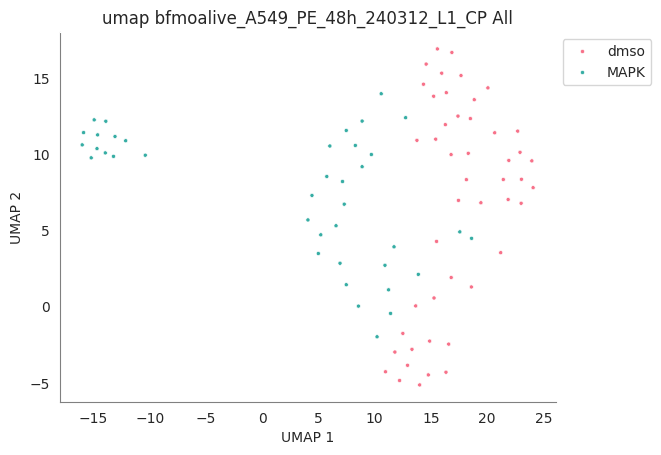

In [24]:
is_super=False
nn = 50
targets = ['dmso','MAPK']
sel_cmpds = ['dmso'] + mapk_selected 
df_twoclass = df.filter(pl.col('Metadata_cmpd_moa_group').is_in(targets))
df_twoclass = df_twoclass.filter(pl.col('Metadata_cmpd_cmpdname').is_in(sel_cmpds))
embedded_df = makeUMAP(df_twoclass, name=filename, nn=nn, is_supervised=is_super, use_pca=False)



In [45]:
# clusterer = hdb.HDBSCAN(
#     min_samples=2,
#     min_cluster_size=12,
# )
# embeddings = embedded_df.select(pl.col(['umap1', 'umap2']))
# embeddings = embeddings.to_numpy()
# clusterer.fit(embeddings)
# labels = clusterer.probabilities_
# labels_hard = clusterer.labels_
# embedded_df = embedded_df.with_columns([
#     pl.Series('class_prob', labels),  
#     pl.Series('class', labels_hard)   
#     ])

In [61]:
# class sklearn.neighbors.NearestNeighbors(*, n_neighbors=5, radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None)
k = 5  # Number of neighbors: tune this parameter based on your specific needs
knn = KNN(n_neighbors=k)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


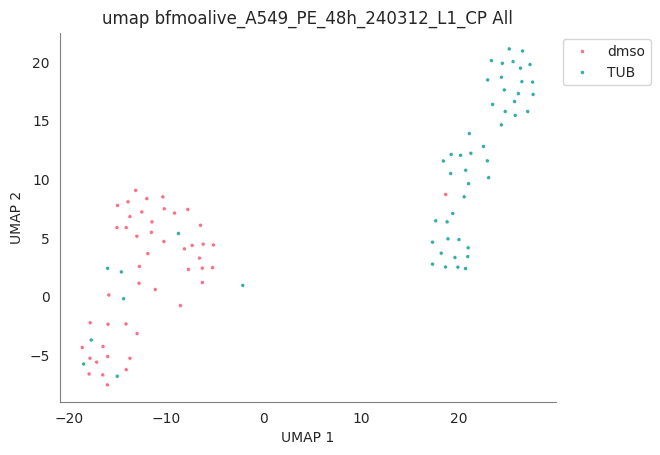

In [28]:
targets = ['dmso','TUB']
sel_cmpds = ['dmso'] + tub_selected 
df_twoclass = df.filter(pl.col('Metadata_cmpd_moa_group').is_in(targets))
df_twoclass = df_twoclass.filter(pl.col('Metadata_cmpd_cmpdname').is_in(sel_cmpds))
_ = makeUMAP(df_twoclass, name=filename, nn=nn, is_supervised=is_super, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


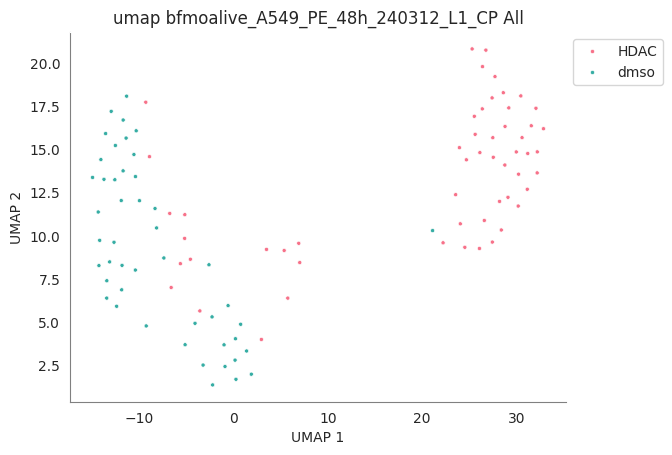

In [29]:
targets = ['dmso','HDAC']
sel_cmpds = ['dmso'] + hdac_selected 
df_twoclass = df.filter(pl.col('Metadata_cmpd_moa_group').is_in(targets))
df_twoclass = df_twoclass.filter(pl.col('Metadata_cmpd_cmpdname').is_in(sel_cmpds))
_ = makeUMAP(df_twoclass, name=filename, nn=nn, is_supervised=is_super, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


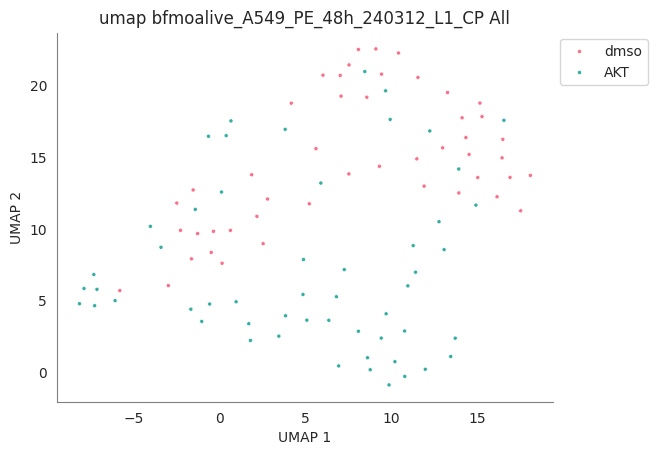

In [30]:
targets = ['dmso','AKT']
sel_cmpds = ['dmso'] + akt_selected 
df_twoclass = df.filter(pl.col('Metadata_cmpd_moa_group').is_in(targets))
df_twoclass = df_twoclass.filter(pl.col('Metadata_cmpd_cmpdname').is_in(sel_cmpds))
_ = makeUMAP(df_twoclass, name=filename, nn=nn, is_supervised=is_super, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


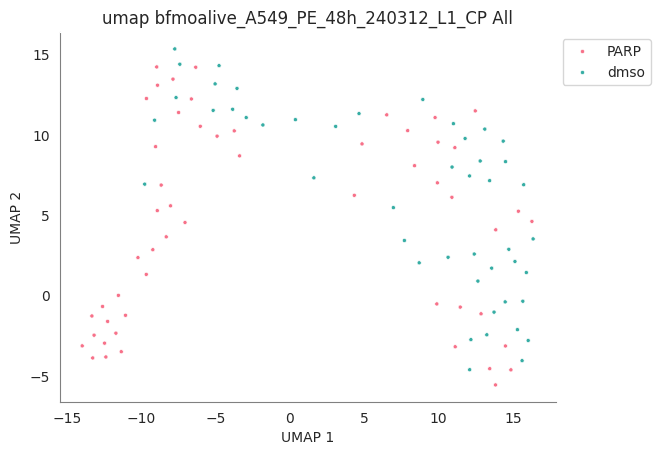

In [31]:
targets = ['dmso','PARP']
sel_cmpds = ['dmso'] + parp_selected 
df_twoclass = df.filter(pl.col('Metadata_cmpd_moa_group').is_in(targets))
df_twoclass = df_twoclass.filter(pl.col('Metadata_cmpd_cmpdname').is_in(sel_cmpds))
_ = makeUMAP(df_twoclass, name=filename, nn=nn, is_supervised=is_super, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


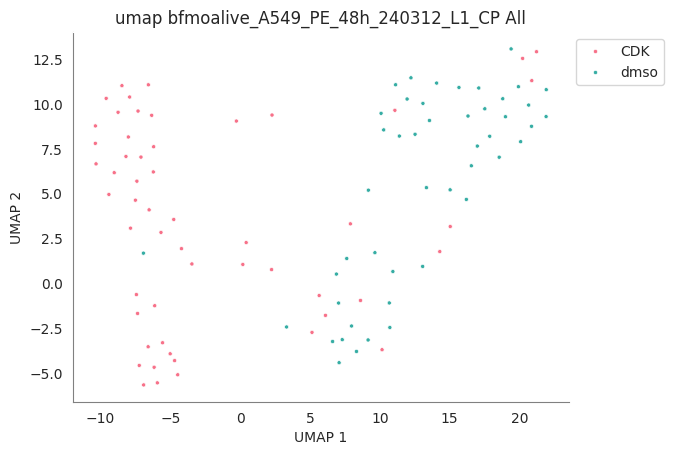

In [32]:
targets = ['dmso','CDK']
sel_cmpds = ['dmso'] + cdk_selected 
df_twoclass = df.filter(pl.col('Metadata_cmpd_moa_group').is_in(targets))
df_twoclass = df_twoclass.filter(pl.col('Metadata_cmpd_cmpdname').is_in(sel_cmpds))
_ = makeUMAP(df_twoclass, name=filename, nn=nn, is_supervised=is_super, use_pca=False)

In [33]:
# df['pc1'].max()

In [34]:
# min_dist=0.2
# spread= 5
# n_epochs=None
# metric='cosine'
# for filename in filenames:
#     df = readData(filename)
#     _ = makePCA(df, name=filename)
#     # _ = makeUMAP(dataNpy, dataL, name=filename)
#     _ = makeUMAP(df, name=filename, nn=250)
#     _ = makeUMAP(df, name=filename, nn=300, is_supervised=False)


In [35]:


# for statmet in statmets:
#     for filename in filenames:
#         dataNpy, dataL = readData(filename, statmet=statmet)
#         _ = makePCA(dataNpy, dataL, name=filename, statmet=statmet)
#         # _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet)
#         _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, nn=150)
#         # _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, is_supervised=False)
#         _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, nn=150, is_supervised=False)

In [36]:
# for filename in filenames:
#     dataNpy, dataL = readData(filename)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='PCA', n_components=5)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', n_components=5)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', is_supervised=False, n_components=5)

In [37]:

# for filename in filenames:
#     dataNpy, dataL = readData(filename, statmet='Mean')
#     _ = makeMultiPlot(dataNpy, dataL, model_type='PCA', statmet='Mean', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Mean', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Mean', is_supervised=False, n_components=5, nn=100)

In [38]:
# for filename in filenames:
#     dataNpy, dataL = readData(filename, statmet='Median')
#     _ = makeMultiPlot(dataNpy, dataL, model_type='PCA', statmet='Median', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Median', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Median', is_supervised=False, n_components=5, nn=100)